In [1]:
import gc
import numpy as np
import scipy.io
from scipy.ndimage import convolve
from scipy.signal import convolve2d
from skimage.color import rgb2gray
from scipy.ndimage import convolve, gaussian_filter
from numpy.fft import fft2, ifft2, fftshift

import scipy.io
from scipy import signal
import cv2
import numpy as np
from scipy.ndimage import zoom
from scipy.signal import convolve2d
from PIL import Image
from scipy.ndimage import convolve
from scipy.ndimage import gaussian_filter, maximum_filter
from scipy.sparse import spdiags, eye
from scipy.sparse.linalg import spsolve
from skimage.color import rgb2gray
from sklearn.neighbors import KDTree
from scipy.signal import fftconvolve
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import scipy.sparse as sparse

# Decomposition

In [2]:
def gradient_weight(I):
    if len(I.shape) == 3 and I.shape[2] == 3:  # If the image has RGB channels
        I = np.dot(I[..., :3], [0.2989, 0.5870, 0.1140])  # Convert to grayscale using standard weights

    lambda_val = 10
    f1 = np.array([[0, 0, 0],[1, -1, 0],[0, 0, 0]])
    f2 = np.array([[0, 1, 0],[0, -1, 0],[0, 0, 0]])
    
    Gx = signal.convolve2d(I, f1, mode='same')
    Gy = signal.convolve2d(I, f2, mode='same')

    ax = np.exp(-lambda_val * np.abs(Gx))
    thx = Gx < 0.01
    ax[thx] = 0
    weight_x = 1 + ax

    ay = np.exp(-lambda_val * np.abs(Gy))
    thy = Gy < 0.01
    ay[thy] = 0
    weight_y = 1 + ay

    return weight_x, weight_y

In [3]:
def psf2otf(psf, shape):
    psf = np.pad(psf, [(0, shape[0] - psf.shape[0]), (0, shape[1] - psf.shape[1])], mode='constant')
    for axis, axis_size in enumerate(psf.shape):
        psf = np.roll(psf, -axis_size // 2, axis=axis)
    otf = fft2(psf.T).T
    return otf

def decomposition(I, alpha, ii, beta, gamma):
    alpha = float(alpha)
    ii = float(ii)
    beta = float(beta)
    gamma = float(gamma)
    I = np.clip(I, 0, 1)
    gray = np.mean(I, axis=2)
    H, W, D = I.shape

    weight_x, weight_y = gradient_weight(I)
    # f1 = np.array([[1, -1]])
    # f2 = np.array([[1], [-1]])
    f1 = np.array([[0, 0, 0],[1, -1, 0],[0, 0, 0]])
    f2 = np.array([[0, 1, 0],[0, -1, 0],[0, 0, 0]])
    f4 = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])

    gray = rgb2gray(I)
    I_filt = gaussian_filter(gray, sigma = 10)
    delta_I = I - I_filt[..., np.newaxis]

    otfFx = psf2otf(f1, (H, W))
    otfFy = psf2otf(f2, (H, W))
    otfL = psf2otf(f4, (H, W))

    fft_double_laplace = np.abs(otfL) ** 2
    fft_double_grad = np.abs(otfFx) ** 2 + np.abs(otfFy) ** 2

    if D > 1:
        fft_double_grad = np.repeat(fft_double_grad[:, :, np.newaxis], D, axis=2)
        fft_double_laplace = np.repeat(fft_double_laplace[:, :, np.newaxis], D, axis=2)
        weight_x = np.repeat(weight_x[:, :, np.newaxis], D, axis=2)
        weight_y = np.repeat(weight_y[:, :, np.newaxis], D, axis=2)

    F = np.zeros_like(I)
    N = np.zeros_like(I)
    gray = rgb2gray(I)

    Ix = np.zeros_like(I)
    Iy = np.zeros_like(I)

    for channel in range(I.shape[2]):
        Ix[:, :, channel] = signal.convolve2d(I[:, :, channel], f1,mode='same')
        Iy[:, :, channel] = signal.convolve2d(I[:, :, channel], f2,mode='same')
        # Ix[:, :, channel] = fft_convolution(I[:, :, channel], f1)
        # Iy[:, :, channel] = fft_convolution(I[:, :, channel], f2)

    Normin_I = fft2((np.concatenate((Ix[:, -1:, :] - Ix[:, :1, :], -np.diff(Ix, 1, 1)), axis=1) +
                   np.concatenate((Iy[-1:, :, :] - Iy[:1, :, :], -np.diff(Iy, 1, 0)), axis=0)).T).T
    Denormin_N = gamma + alpha * fft_double_laplace + beta
    Normin_gI = fft_double_laplace * fft2(I.T).T

    # return(F, I_filt, delta_I, fft_double_laplace, fft_double_grad, Normin_I, Denormin_N, Normin_gI)

    i = 0
    while True:
        i += 1
        prev_F = F.copy()

        lambda_ = min(2 ** (ii + i), 10 ** 5)
        Denormin_F = lambda_ * fft_double_grad + alpha * fft_double_laplace + beta

        qx = np.zeros_like(I)
        qy = np.zeros_like(I)
        for channel in range(I.shape[2]):
            qx[:, :, channel] = signal.convolve2d(I[:, :, channel], f1,mode='same') - Ix[:,:,channel]
            qy[:, :, channel] = signal.convolve2d(I[:, :, channel], f2,mode='same') - Iy[:,:,channel]

        qx = np.sign(qx) * np.maximum(np.abs(qx) - weight_x / lambda_, 0)
        qy = np.sign(qy) * np.maximum(np.abs(qy) - weight_y / lambda_, 0)

        Normin_q = np.concatenate((qx[:, -1:, :] - qx[:, :1, :], -np.diff(qx, 1, 1)), axis=1) + \
                    np.concatenate((qy[-1:, :, :] - qy[:1, :, :], -np.diff(qy, 1, 0)), axis=0)
        Normin_gN = fft_double_laplace * fft2(N.T).T

        FF = (lambda_ * (Normin_I + fft2(Normin_q.T).T) +
              alpha * (Normin_gI - Normin_gN) + beta * fft2((delta_I - N).T).T) / Denormin_F
        F = np.real(ifft2(FF.T).T)

        Normin_F = fft_double_laplace * fft2(F.T).T
        B = fft2((delta_I - F).T).T
        NN = (alpha * (Normin_gI - Normin_F) + beta * B) / Denormin_N
        N = np.real(ifft2(NN.T).T)
        print(np.sum(np.abs(prev_F - F)) / (H * W))
        if np.sum(np.abs(prev_F - F)) / (H * W) < 10 ** (-1):
            break
    for c in range(D):
        Ft = F[:, :, c]
        q = np.size(Ft)
        for k in range(500):
            m = np.sum(Ft[Ft < 0])
            n = np.sum(Ft[Ft > 1] - 1)
            dt = (m + n) / q
            if np.abs(dt) < 1 / q:
                break
            Ft = Ft - dt
        F[:, :, c] = Ft

    F = np.abs(F)
    F[F > 1] = 1

    N[N > 1] = 1
    N[N < 0] = 0
    N = np.mean(N, axis=2)

    G = np.abs(I - F - N[:, :, np.newaxis])
    G = np.min(G, axis=2)
    G = gaussian_filter(G, 3)

    F = np.abs(I - G[:, :, np.newaxis] - N[:, :, np.newaxis])
    F[F == 0] = 0.001

    return F, G, N

# parameter_sel

In [4]:

def lemire_nd_maxengine(A, idx, window, shapeflag):
    original_A_dim = len(A.shape)  # Store the original dimension of A

    # Inputs validation
    if A.shape == idx.shape:
        print('The dimensions of the two arrays are the same.')

    sz = A.shape
    if len(sz) == 2:
        A = A[:, :, np.newaxis]  # Adding a new third dimension
        sz = A.shape

    if len(sz) == 3 and len(idx.shape) == 2:
        if sz[0] == 1:  # Special case where first dimension of A is 1
            idx = np.reshape(idx, (1, idx.shape[0], idx.shape[1]))
        else:
            idx = np.reshape(idx, (idx.shape[0], idx.shape[1], 1))

    if len(A.shape) != 3 or len(idx.shape) != 3:
        raise ValueError('Not enough input arguments.')


    p, n, q = A.shape
    pi, ni, qi = idx.shape

    if pi != p or ni != n:
        raise ValueError('A and idx must have the same first two dimensions.')
    if qi == 0:
        qi = 1
    if q != qi:
        raise ValueError('A and idx must have the same third dimension or idx should not have a third dimension.')

    # Initialize outputs
    maxval = np.zeros(A.shape)
    maxidx = np.zeros(idx.shape)

    for j in range(q):
        for k in range(p):
            a = A[k, :, j]
            current_idx = idx[k, :, min(j, qi-1)]
            nWedge = 0
            Wedgefirst = 0
            Wedgelast = -1
            left = -window
            Wedge = np.zeros(n, dtype=int)  # Explicitly set dtype to int

            # Loop over the second dimension
            for i in range(n):
                left += 1

                # Update the wedge
                while nWedge > 0 and a[Wedge[Wedgelast]] <= a[i]:
                    nWedge -= 1
                    Wedgelast -= 1
                if nWedge > 0 and Wedge[Wedgefirst] <= left - window:
                    nWedge -= 1
                    Wedgefirst += 1
                nWedge += 1
                Wedgelast += 1
                Wedge[Wedgelast] = int(i)  # Explicitly cast to int

                # Retrieve the max value and its index
                if i >= window:
                    maxval[k, i-window, j] = a[Wedge[Wedgefirst]]
                    maxidx[k, i-window, j] = current_idx[Wedge[Wedgefirst]]

    # Handle the shapeflag
    if shapeflag == 1: # valid
        maxval = maxval[:, window-1:, :]
        maxidx = maxidx[:, window-1:, :]
    elif shapeflag == 3: # full
        maxval = np.vstack([np.zeros((p, window-1, q)), maxval])
        maxidx = np.vstack([np.zeros((p, window-1, q)), maxidx])

    if original_A_dim == 2:
        maxval = maxval.squeeze(axis=2)
        maxidx = maxidx.squeeze(axis=2)

    return maxval, maxidx


def lemire_nd_minengine(A, idx, window, shapeflag):
    if A.shape != idx.shape:
        raise ValueError("A and idx must have the same shape.")

    if window < 1:
        raise ValueError("window must be 1 or greater.")

    p, n, q = A.shape[0], A.shape[1], A.shape[2]
    margin = window - 1
    size = window + 1
    Wedge = np.zeros(size, dtype=int)

    if shapeflag == 3:  # FULL_SHAPE
        lstart = -margin
        dimOut1 = n + margin
    elif shapeflag == 2:  # SAME_SHAPEx
        lstart = -margin // 2
        dimOut1 = n
    else:  # VALID_SHAPE
        lstart = 0
        dimOut1 = n - margin

    imax = dimOut1 + margin + lstart

    minval = np.empty((p, dimOut1, q), dtype=A.dtype)
    minidx = np.empty((p, dimOut1, q))

    for j in range(q):
        for k in range(p):
            nWedge = 0
            Wedgefirst = 0
            Wedgelast = -1
            left = -window
            pleft = 0
            for i in range(1, n):
                left += 1
                if left >= lstart:
                    linidx = k if nWedge == 0 else k + p*Wedge[Wedgefirst]
                    minidx[k, pleft, j] = idx[k, linidx, j]
                    minval[k, pleft, j] = A[k, linidx, j]
                    pleft += 1
                if A[k, i, j] < A[k, i-1, j]:
                    while nWedge:
                        if A[k, i, j] >= A[k, p*Wedge[Wedgelast], j]:
                            if left == Wedge[Wedgefirst]:
                                nWedge -= 1
                                Wedgefirst = (Wedgefirst + 1) % size
                            break
                        nWedge -= 1
                        Wedgelast = (Wedgelast - 1) % size
                else:
                    nWedge += 1
                    Wedgelast = (Wedgelast + 1) % size
                    Wedge[Wedgelast] = i - 1
                    if left == Wedge[Wedgefirst]:
                        nWedge -= 1
                        Wedgefirst = (Wedgefirst + 1) % size
            for i in range(n, imax + 1):
                left += 1
                linidx = k if nWedge == 0 else k + p*Wedge[Wedgefirst]
                minidx[k, pleft, j] = idx[k, linidx, j]
                minval[k, pleft, j] = A[k, linidx, j]
                pleft += 1
                nWedge += 1
                Wedgelast = (Wedgelast + 1) % size
                Wedge[Wedgelast] = n - 1
                if left == Wedge[Wedgefirst]:
                    nWedge -= 1
                    Wedgefirst = (Wedgefirst + 1) % size

    return minval, minidx



def minmaxfilt(A, window=3, outtype='both', shape='valid'):
    if outtype not in ['both', 'minmax', 'maxmin', 'min', 'max']:
        raise ValueError(f"Unknown outtype {outtype}")
    if shape not in ['valid', 'same', 'full']:
        raise ValueError(f"Unknown shape {shape}")

    shapeloc_map = {'valid': 1, 'same': 2, 'full': 3}
    shapeloc = shapeloc_map[shape]

    if np.isscalar(window):
        window = [window] * A.ndim
    else:
        while len(window) < A.ndim:
            window.append(1)

    results = []
    idx_results = []

    # Min Filter
    if outtype != 'max':
        minval = np.copy(A)
        minidx = np.arange(np.prod(A.shape)).reshape(A.shape).astype(np.float64)
        for dim in range(A.ndim):
            shape_dim = minval.shape[dim]
            if window[dim] != 1:
                minval, minidx = lemire_nd_minengine(minval, minidx, window[dim], shapeloc)
            if minval.shape[dim] != shape_dim:
                shape = list(minval.shape)
                shape[dim] = shape_dim
                minval = minval.reshape(shape)
                minidx = minidx.reshape(shape)
        results.append(minval)
        idx_results.append(minidx)

    # Max Filter
    if outtype != 'min':
        maxval = np.copy(A)
        maxidx = np.arange(np.prod(A.shape)).reshape(A.shape).astype(np.float64)
        for dim in range(A.ndim):
            shape_dim = maxval.shape[dim]
            if window[dim] != 1:
                maxval, maxidx = lemire_nd_maxengine(maxval, maxidx, window[dim], shapeloc)
            if maxval.shape[dim] != shape_dim:
                shape = list(maxval.shape)
                shape[dim] = shape_dim
                maxval = maxval.reshape(shape)
                maxidx = maxidx.reshape(shape)
        results.append(maxval)
        idx_results.append(maxidx)

    if len(results) == 1:
        return results[0], idx_results[0]
    return tuple(results + idx_results)

def parameter_sel(img_hazy):
    I = img_hazy
    gray = np.max(I, axis=2)

    # Gaussian filter
    f = gaussian_filter(gray, sigma=10)

    # Laplacian filter
    f3 = np.array([
        [0, -1, 0],
        [-1, 4, -1],
        [0, -1, 0]
    ])

    shap = np.abs(convolve2d(gray, f3, mode='same'))
    shap = shap[10:-10, 10:-10]

    # Applying the maximum filter (which is equivalent to the minmaxfilt in MATLAB with 'max' argument)
    shap = maximum_filter(shap, size=20)

    # Apply the Gaussian filter multiple times
    for _ in range(4):
        gray = gaussian_filter(gray, sigma=10)

    gray = gray[10:-10, 10:-10]

    ratio = np.sum(gray) / np.sum(shap)
    alpha = 50
    beta = 0.001
    pro = 1.6

    if ratio > 2.3:
        beta = 0.01
        pro = 2.3

    return alpha, beta, pro

# Estimate air light

In [5]:
def generate_Avals(Avals1, Avals2):
    # Reshape the input arrays
    Avals1 = Avals1.reshape(-1, 1)
    Avals2 = Avals2.reshape(-1, 1)

    # Use numpy's kron function to replicate the behavior of MATLAB's kron
    A1 = np.kron(Avals1, np.ones_like(Avals2))
    A2 = np.kron(np.ones_like(Avals1), Avals2)

    # Concatenate A1 and A2 horizontally
    Aall = np.hstack((A1, A2))

    return Aall


def vote_2D(points, points_weight, directions_all, Aall, thres):
    n_directions = directions_all.shape[0]
    accumulator_votes_idx = np.zeros((Aall.shape[0], points.shape[0], n_directions), dtype=bool)

    for i_point in range(points.shape[0]):
        for i_direction in range(n_directions):
            idx_to_use = np.where((Aall[:, 0] > points[i_point, 0]) & (Aall[:, 1] > points[i_point, 1]))[0]

            if len(idx_to_use) == 0:
                continue

            dist1 = np.sqrt((Aall[idx_to_use, 0] - points[i_point, 0])**2 +
                            (Aall[idx_to_use, 1] - points[i_point, 1])**2)
            dist1 = dist1 / np.sqrt(2) + 1

            dist = (-points[i_point, 0] * directions_all[i_direction, 1] +
                    points[i_point, 1] * directions_all[i_direction, 0] +
                    Aall[idx_to_use, 0] * directions_all[i_direction, 1] -
                    Aall[idx_to_use, 1] * directions_all[i_direction, 0])

            idx = np.abs(dist) < 2 * thres * dist1
            if not np.any(idx):
                continue

            idx_full = idx_to_use[idx]
            accumulator_votes_idx[idx_full, i_point, i_direction] = True

    accumulator_votes_idx2 = np.sum(accumulator_votes_idx.astype(np.uint8), axis=2) >= 2
    accumulator_votes_idx = accumulator_votes_idx & accumulator_votes_idx2[:, :, None]

    accumulator_unique = np.zeros(Aall.shape[0])
    for iA in range(Aall.shape[0]):
        idx_to_use = np.where((Aall[iA, 0] > points[:, 0]) & (Aall[iA, 1] > points[:, 1]))[0]
        points_dist = np.sqrt((Aall[iA, 0] - points[idx_to_use, 0])**2 +
                              (Aall[iA, 1] - points[idx_to_use, 1])**2)
        points_weight_dist = points_weight[idx_to_use] * (5 * np.exp(-points_dist) + 1)
        accumulator_unique[iA] = np.sum(points_weight_dist[np.any(accumulator_votes_idx[iA, idx_to_use], axis=1)])

    Aestimate_idx = np.argmax(accumulator_unique)
    Aout = Aall[Aestimate_idx, :]
    Avote2 = accumulator_unique.reshape(-1, 1)

    return Aout, Avote2

from PIL import Image
import numpy as np

def rgb2ind(img, m=None, dither='dither'):
    """
    Convert an RGB image to indexed image.
    :param img: RGB image (PIL.Image format or numpy array)
    :param m: can be:
        - a colormap (numpy array of shape (num_colors, 3))
        - a number N representing the number of desired colors
        - a value < 1 (tolerance) for uniform quantization
    :param dither: can be 'dither' or 'nodither'
    :return: indexed image, colormap
    """

    if isinstance(img, np.ndarray):
        img = Image.fromarray((img * 255).astype(np.uint8))

    def assign_colormap(value):
        nonlocal colormap
        # If value is a tolerance for uniform quantization
        if value < 1:
            max_colors = 65536
            N = round(1 / value)
            # Check maximum allowed value
            if N * N * N > max_colors:
                N = int(max_colors ** (1/3)) - 1

            r = np.linspace(0, 255, N, dtype=int)
            g = np.linspace(0, 255, N, dtype=int)
            b = np.linspace(0, 255, N, dtype=int)
            colormap = np.array([(ri, gi, bi) for ri in r for gi in g for bi in b])

        # Else, value is N, the number of desired colors
        else:
            value = min(value, 256)
            colormap = img.quantize(colors=int(value)).getpalette()[:3*int(value)]
            colormap = np.array(colormap).reshape((-1, 3))

    # If m is None, just convert RGB to grayscale and use that as index
    if m is None:
        indexed_img = img.convert("L")
        colormap = np.array([[i, i, i] for i in range(256)])
        return indexed_img, colormap

    # If m is a single number
    if isinstance(m, (int, float)):
        assign_colormap(m)

    elif isinstance(m, np.ndarray) and m.shape == (1, 1):
        assign_colormap(int(m[0][0]))

    # If m is already a colormap
    else:
        colormap = np.array(m).reshape((-1, 3))

    # Convert the colormap to a PIL image
    palette_img = Image.new('P', (1, 1))
    palette_img.putpalette(colormap.astype('uint8').ravel())

    # Convert image using the colormap
    if dither == 'dither':
        indexed_img = img.quantize(palette=palette_img, dither=Image.NONE)
    elif dither == 'nodither':
        indexed_img = img.quantize(palette=palette_img, dither=Image.NONE)
    else:
        raise ValueError("Invalid dither option. Use 'dither' or 'nodither'.")

    return np.array(indexed_img), colormap/(colormap.max()*2)


import numpy as np

def estimate_airlight(gamma, img, Amin=[0, 0.05, 0.1], Amax=1, N=1000, spacing=0.02, K=40, thres=0.01):
    img = img[::2, ::2, :]  # Reducing the resolution (equivalent to impyramid('reduce'))
    img = img**gamma
    img_ind, points = rgb2ind(img, N)
    h, w, _ = img.shape

    # Remove empty clusters
    idx_in_use = np.unique(img_ind)
    idx_to_remove = np.setdiff1d(np.arange(points.shape[0]), idx_in_use)
    points = np.delete(points, idx_to_remove, axis=0)

    img_ind_sequential = np.zeros((h, w), dtype=int)
    for i, idx in enumerate(idx_in_use, start=1):
        img_ind_sequential[img_ind == idx] = i

    # Count the occurrences of each index - this is the clusters' weight
    points_weight = np.bincount(img_ind_sequential.ravel(), minlength=points.shape[0])
    points_weight = points_weight / (h * w)

    # Define arrays of candidate air-light values and angles
    angle_list = np.linspace(0, np.pi, K)
    directions_all = np.column_stack((np.sin(angle_list[:-1]), np.cos(angle_list[:-1])))

    # Air-light candidates in each color channel
    ArangeR = np.arange(Amin[0], Amax + spacing, spacing)
    ArangeG = np.arange(Amin[1], Amax + spacing, spacing)
    ArangeB = np.arange(Amin[2], Amax + spacing, spacing)

    Aall = generate_Avals(ArangeR, ArangeG)
    _, AvoteRG = vote_2D(points[:, :2], points_weight, directions_all, Aall, thres)
    AvoteRG2 = AvoteRG.ravel()

    Aall = generate_Avals(ArangeG, ArangeB)
    _, AvoteGB = vote_2D(points[:, 1:3], points_weight, directions_all, Aall, thres)
    AvoteGB2 = AvoteGB.ravel()

    Aall = generate_Avals(ArangeR, ArangeB)
    _, AvoteRB = vote_2D(points[:, [0, 2]], points_weight, directions_all, Aall, thres)
    AvoteRB2 = AvoteRB.ravel()

    # Ensure array dimensions are consistent
    assert len(AvoteRG2) == len(ArangeR) * len(ArangeG), "Mismatch in AvoteRG2 dimensions"
    assert len(AvoteRB2) == len(ArangeR) * len(ArangeB), "Mismatch in AvoteRB2 dimensions"
    assert len(AvoteGB2) == len(ArangeG) * len(ArangeB), "Mismatch in AvoteGB2 dimensions"

    # Normalize
    max_val = max(AvoteRB2.max(), AvoteRG2.max(), AvoteGB2.max())
    AvoteRG2 = AvoteRG2 / max_val
    AvoteGB2 = AvoteGB2 / max_val
    AvoteRB2 = AvoteRB2 / max_val

    AvoteAll = np.zeros((len(ArangeR), len(ArangeG), len(ArangeB)))

    for i, val_r in enumerate(ArangeR):
        for j, val_g in enumerate(ArangeG):
            for k, val_b in enumerate(ArangeB):
                AvoteAll[i, j, k] = AvoteRG2[i * len(ArangeG) + j] * AvoteRB2[i * len(ArangeB) + k] * AvoteGB2[j * len(ArangeB) + k]

    idx = np.unravel_index(AvoteAll.argmax(), AvoteAll.shape)
    Aout = (ArangeR[idx[0]], ArangeG[idx[1]], ArangeB[idx[2]])

    return np.asarray(Aout)*2


# Non local Dehazing

In [6]:
from itertools import product
import numpy as np


def accum(accmap, a, func=None, size=None, fill_value=0, dtype=None):

    # Check for bad arguments and handle the defaults.
    if accmap.shape[:a.ndim] != a.shape:
        raise ValueError("The initial dimensions of accmap must be the same as a.shape")
    if func is None:
        func = np.sum
    if dtype is None:
        dtype = a.dtype
    if accmap.shape == a.shape:
        accmap = np.expand_dims(accmap, -1)
    adims = tuple(range(a.ndim))
    if size is None:
        size = 1 + np.squeeze(np.apply_over_axes(np.max, accmap, axes=adims))
    size = np.atleast_1d(size)

    # Create an array of python lists of values.
    vals = np.empty(size, dtype='O')
    for s in product(*[range(k) for k in size]):
        vals[s] = []
    for s in product(*[range(k) for k in a.shape]):
        indx = tuple(accmap[s])
        val = a[s]
        vals[indx].append(val)

    # Create the output array.
    out = np.empty(size, dtype=dtype)
    for s in product(*[range(k) for k in size]):
        if vals[s] == []:
            out[s] = fill_value
        else:
            out[s] = func(vals[s])

    return out

In [7]:
def wls_filtler(in_, data_term_weight, guidance, lambda_=0.05, small_num=0.00001):
    h, w, _ = guidance.shape
    k = h * w

    guidance = cv2.cvtColor(guidance, cv2.COLOR_RGB2GRAY).tolist()

    # Compute affinities between adjacent pixels based on gradients of guidance
    dy = np.diff(guidance, axis=0)
    dy = - lambda_ / (np.abs(dy) ** 2 + small_num)
    dy = np.pad(dy, ([0, 1], [0, 0]), 'constant', constant_values=0)
    dy = dy.flatten('F').T

    dx = np.diff(guidance, axis=1)
    dx = -lambda_ / (np.abs(dx) ** 2 + small_num)
    dx = np.pad(dx, ([0, 0], [0, 1]), 'constant', constant_values=0)
    dx = dx.flatten(order='F').T

    B = np.vstack((dx, dy))
    d = [-h, -1]
    tmp = sparse.spdiags(B, d, k, k)
    # row vector
    ea = dx
    temp = [dx]
    we = np.pad(temp, ([0, 0], [h, 0]), mode='constant')[0]
    we = we[0:len(we) - h]

    # row vector
    so = dy
    temp = [dy]
    no = np.pad(temp, ([0, 0], [1, 0]), mode='constant')[0]
    no = no[0:len(no) - 1]

    # row vector
    D = -(ea + we + so + no)
    Asmoothness = tmp + tmp.T + sparse.spdiags(D, 0, k, k)
    # Normalize data weight
    data_weight = data_term_weight - np.min(data_term_weight)

    data_weight = data_weight / (np.max(data_weight) + small_num)

    # Make sure we have a boundary condition for the top line:
    # It will be the minimum of the transmission in each column
    # With reliability 0.8
    reliability_mask = np.where(data_weight[0] < 0.6, 1, 0)
    in_row1 = np.min(in_, axis=0)
    # print(reliability_mask)
    for i in range(w):
        if reliability_mask[i] == 1:
            data_weight[0][i] = 0.8

    for i in range(w):
        if reliability_mask[i] == 1:
            in_[0][i] = in_row1[i]

    Adata = sparse.spdiags(data_weight.flatten(), 0, k, k)

    A = Asmoothness + Adata

    b = Adata * in_.flatten(order='F').T

    X = spsolve(A, b)

    out = np.reshape(X, [h, w], order='F')
    return out

In [8]:
def non_local_dehazing(img_hazy, air_light):
    air_light = air_light.squeeze()
    # Validate input
    h, w, n_colors = img_hazy.shape
    row = h
    col = w
    img_hazy_corrected = img_hazy.copy()

    # Find Haze-lines
    dist_from_airlight = np.zeros((h, w, n_colors), dtype=np.float32)
    for color_idx in range(n_colors):
        dist_from_airlight[:,:,color_idx] = img_hazy_corrected[:,:,color_idx] - air_light[color_idx].reshape(1, 1)


    radius = np.sqrt(np.sum(np.square(dist_from_airlight.copy()), axis=2))

    # Cluster the pixels to haze-lines
    dist_unit_radius = np.reshape(dist_from_airlight.copy(), (h*w, n_colors))
    dist_norm = np.sqrt(np.sum(np.square(dist_unit_radius), axis=1))
    dist_unit_radius /= dist_norm[:, np.newaxis]

    # This assumes you've loaded the file 'TR1000.txt' and contains the points
    points = np.loadtxt('./TR1000.txt')
    kdtree = KDTree(points)
    dist, ind = kdtree.query(dist_unit_radius)

    # Estimating Initial Transmission
#     K = np.bincount(ind, weights=radius.ravel(), minlength=len(points))
    K = accum(ind.ravel(), radius.ravel(), func=np.max, size=len(points))
    radius_new = np.reshape(K[ind], (h, w))
    transmission_estimation = np.divide(radius, radius_new)

    trans_min = 0.1
    transmission_estimation = np.clip(transmission_estimation, trans_min, 1)

    # Regularization
    trans_lower_bound = 1 - np.min(img_hazy_corrected / air_light, axis=2)
    transmission_estimation = np.maximum(transmission_estimation, trans_lower_bound)

#-------------------------------------------
    n_points = 1000
    cluster_Points = ind
    bin_count = np.zeros(n_points, int)
    for index in cluster_Points:
        bin_count[index] += 1

    bin_count_map = np.zeros((row, col), np.int)
    radius_std = np.zeros((row, col), np.float)

    K_std = accum(ind.ravel(), radius.ravel(), func=np.std, size=len(points))

    for i in range(row * col):
        index = cluster_Points[i]
        bin_count_map[int(i / col)][int(i % col)] = bin_count[index]
        radius_std[int(i / col)][int(i % col)] = K_std[index]

    max_radius_std = np.max(radius_std)
    temp = radius_std / max_radius_std - 0.1
    temp = np.where(temp > 0.001, temp, 0.001) * 3

    radius_reliability = np.where(temp > 1, 1, temp)

    temp2 = np.where(bin_count_map > 1, 1, bin_count_map / 50)

    data_term_weight = temp2 * radius_reliability
    lambd = 0.1

    trans = np.reshape(transmission_estimation, (row, col), order='F')

    transmission_estimation = wls_filtler(trans, data_term_weight, img_hazy_corrected.astype(np.float32), lambd)
#---------------------------------------

    # Dehazing
    img_dehazed = np.zeros((h, w, n_colors))
    leave_haze = 1
    trans_min = 0.1
    for color_idx in range(3):
        img_dehazed[:,:,color_idx] = (img_hazy_corrected[:,:,color_idx] - (1-leave_haze*transmission_estimation)*air_light[color_idx]) / np.maximum(transmission_estimation, trans_min)

    img_dehazed = np.clip(img_dehazed, 0, 1)

    return img_dehazed, transmission_estimation

# Compensation

In [9]:
def Background(RGB):
    height, width, _ = RGB.shape
    patchSize = 3
    padSize = 1  # half the patch size
    JBack = np.zeros((height, width))

    # Padding the RGB image with Inf (We use a high value to simulate Inf since actual Infinity might cause issues)
    imJ = np.pad(RGB, [(padSize, padSize), (padSize, padSize), (0, 0)], mode='constant', constant_values=1)

    for j in range(height):
        for i in range(width):
            # Extracting the patch
            patch = imJ[j:j+patchSize, i:i+patchSize, :]

            # Assigning the maximum value of the patch to JBack
            JBack[j, i] = np.max(patch)

    return JBack

def Compensation(fog_free_layer, G):
    # Compute the background
    JBack = np.abs(Background(fog_free_layer))

    # Display using Matplotlib
#     plt.imshow(JBack, cmap='gray')
#     plt.show()

    # Save the data using SciPy's savemat
    scipy.io.savemat('Background.mat', {'fog_free_layer': fog_free_layer, 'JBack': JBack})

    # Clip and modify values in JBack
    JBack[JBack > 1] = 1
    JBack[JBack == 0] = 0.001

    # Calculate GR and Gm
    GR = G[:,:,np.newaxis] * fog_free_layer
    Gm = GR / JBack[:,:,np.newaxis]

    return Gm


In [10]:
def mean_absolute_error(y_true, y_pred):
    """
    Calculate the Mean Absolute Error between two arrays of values.

    Parameters:
    y_true (numpy array or list): Actual values
    y_pred (numpy array or list): Predicted values

    Returns:
    float: The Mean Absolute Error
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    
    if y_true.shape != y_pred.shape:
        raise ValueError("Input arrays must have the same shape.")
    
    mae = np.mean(np.abs(y_true - y_pred))
    return mae

In [20]:
import numpy as np
import cv2  # OpenCV for image processing

def Defogging(input_img,air_light = [],ii = 5):
    adjust_fog_removal = 2
    brightness = 2

    # Convert image from uint8 to float32 (similar to im2double)
    input_img = input_img.astype(np.float32) / input_img.max()
    alpha = 20000
    beta = 0.1
    gamma = 10

#     _, haze_level, _ = parameter_sel(input_img)
#     if haze_level == 0.01:
#         ii = 7
#     elif haze_level == 0.001:
#         ii = 5
#     print(ii)
    F, G, _ = decomposition(input_img, alpha, ii, beta, gamma)
    gc.collect()

    # Dehaze the image
    if(len(air_light)==0):
        A = estimate_airlight(adjust_fog_removal, F)
        A = np.reshape(A, (1, 1, 3))
    else:
        A = np.array(air_light)
        A = np.reshape(A, (1, 1, 3))
    gc.collect()
    Shape = F.shape
    if(Shape[0]>1000 or Shape[1]>1000):
        F2 = [scipy.ndimage.interpolation.zoom(F[:,:,0],0.5,order=1),
             scipy.ndimage.interpolation.zoom(F[:,:,1],0.5,order=1),
             scipy.ndimage.interpolation.zoom(F[:,:,2],0.5,order=1)]
        F2 = np.moveaxis(np.array(F2),0,-1)
        fog_free_layer, _ = non_local_dehazing(F2, A)
        fog_free_layer2 = np.zeros(Shape)
        temp = [scipy.ndimage.interpolation.zoom(fog_free_layer[:,:,0],2,order=1),
                scipy.ndimage.interpolation.zoom(fog_free_layer[:,:,1],2,order=1),
                scipy.ndimage.interpolation.zoom(fog_free_layer[:,:,2],2,order=1)]
        temp = np.moveaxis(np.array(temp),0,-1)
        fog_free_layer2[:np.min([temp.shape[0],Shape[0]]),:np.min([temp.shape[1],Shape[1]]),:] = temp[:np.min([temp.shape[0],Shape[0]]),:np.min([temp.shape[1],Shape[1]]),:]
        fog_free_layer = fog_free_layer2
        
    else:
        fog_free_layer, _ = non_local_dehazing(F, A)
    gc.collect()
    # fog_free_layer = fog_free_layer+.3
    # fog_free_layer = fog_free_layer/fog_free_layer.max()

    # Compensation
        
    Gm = Compensation(fog_free_layer, G)
    result = fog_free_layer + brightness * Gm

    gray = cv2.cvtColor((result * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY)
    if np.median(gray) < 128:
        print('I am here...')
        result = fog_free_layer + Gm
    result = result/np.max(result)
    return result, F, G

0.2837362577540902
0.08154470134297769


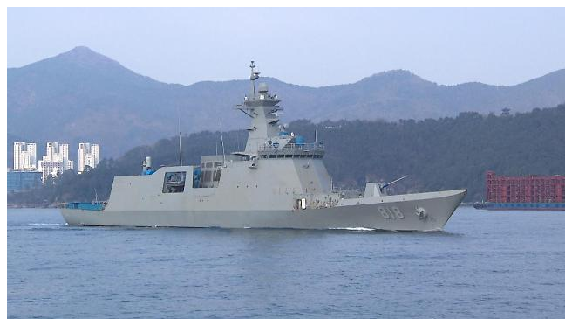

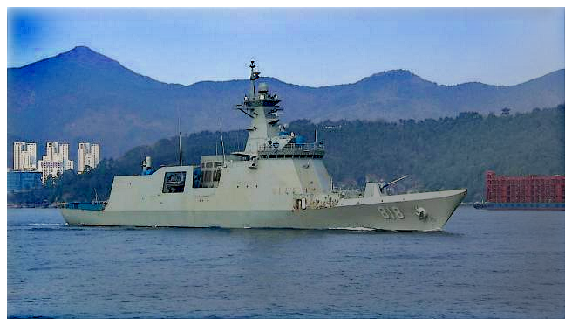

In [22]:

# Replace the path with your image path
foggy_image_path = r'F:\Azaab work\python files\Test_Data\V_07_01_0017.jpg'

# Read the image using OpenCV
foggy_image = cv2.imread(foggy_image_path)

# Convert the image from BGR to RGB (OpenCV reads images in BGR format)
foggy_image = cv2.cvtColor(foggy_image, cv2.COLOR_BGR2RGB)

# Get the defogged image
defogged_image, F, G = Defogging(foggy_image,air_light = [.20,.21,.3],ii=5)

defogged_image = (defogged_image * 255).astype(np.uint8)



plt.figure(figsize=(10,10))
plt.imshow(foggy_image)
plt.axis('off')
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(defogged_image)
plt.axis('off')
plt.show()